### Libraries

In [1]:
# import csv
# import os
import re
import json
import umap

import hdbscan

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate

### Load Data

In [2]:
query = "Query_AI-magazines-mediacloud-2021-24" # Load feater file
FEATHER_FILE = query + ".feather"
df = pd.read_feather('data/' + FEATHER_FILE)

df = df[df['text'] != ''] # Drop rows where the 'Name' is empty
df = df[pd.to_numeric(df['year'], errors='coerce').notnull()] # Remove cells without integer

df = df.reset_index(drop=True) # Reset the index of the DataFrame and drop the old index column


df.sample(1)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG
584,c862b272cd88c46c5a1c2e5353b7500ac1df57d007269c...,2024-01-29 02:45:57,en,wired.com,wired.com,2024-01-27,23andMe Failed to Detect Account Intrusions fo...,https://www.wired.com/story/23andme-failed-to-...,2024,Police took a digital rendering of a suspect's...,True,"[United States, US, California, US, Florida, W...","[Ron Wyden, Joseph Cox]","[NSA, NSO Group, Microsoft, Hewlett-Packard En..."


### Clean Data

In [3]:
def remove_single_word_names(individuals):
    return [name for name in individuals if " " in name] # Function to filter names in 'IND' column
df['IND'] = df['IND'].apply(remove_single_word_names) # Apply the function to the 'IND' column

df = df[df['media_name'].str.contains("technologyreview", na=False)]

def concat_entities(row):
    concat = list(row['GPE']) + list(row['IND']) + list(row['ORG'])
    return list(set(concat))
df['entities'] = df.apply(concat_entities, axis=1) # Merge entities

df = df.drop(['text_downloaded', 'indexed_date', 'language', 'media_url', 'id', 'text', 'publish_date', 'media_name', 'GPE', 'IND', 'ORG'], axis=1) # Delete unised arrows

df.sample(3)

,title,url,year,entities
1536,Using technology to power the future of banking,https://www.technologyreview.com/2022/08/15/10...,2022,"[the Paycheck Protection Program, US, PayPal, ..."
1227,Video: Geoffrey Hinton talks about the “existe...,https://www.technologyreview.com/2023/05/03/10...,2023,"[AI\nWatch Hinton, Will Douglas Heaven, Google..."
878,This robotic exoskeleton can help runners spri...,https://www.technologyreview.com/2023/09/27/10...,2023,"[exosuits, Kaspar Althoefer, the Center for Ad..."


### Temperature

In [4]:
min_year = df['year'].min(); max_year = df['year'].max() # Find min and max
mid_year = (max_year + min_year) // 2 # Calculate the middle year
df['temperature'] = df['year'].apply(lambda x: x - mid_year) # Apply the transformation

# Function to interpolate between red (#FF0000) and blue (#0000FF)
def year_to_color(year, min_year, max_year):
    norm = (year - min_year) / (max_year - min_year)  # Normalize between 0 and 1
    return mcolors.to_hex((1-norm, 0, norm))  # Interpolate between red (1, 0, 0) and blue (0, 0, 1)

# Apply the color function based on the year
df['color'] = df['year'].apply(lambda x: year_to_color(x, min_year, max_year))


df.sample(3)

,title,url,year,entities,temperature,color
193,AI lie detectors are better than humans at spo...,https://www.technologyreview.com/2024/07/05/10...,2024,"[the University of Würzburg, US, International...",2,#0000ff
531,Watch this robot as it learns to stitch up wounds,https://www.technologyreview.com/2024/02/22/10...,2024,"[Ken Goldberg, STAR, Super Mario, Genie, the d...",2,#0000ff
701,Finding value in generative AI for financial s...,https://www.technologyreview.com/2023/11/26/10...,2023,"[MIT Technology Review Insights, TikTok, Insig...",1,#5500aa


### Term Frequency

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

vectorizer = CountVectorizer(
    lowercase=False,
    tokenizer=lambda key: key,  # Use if 'entities' is a list of lists
    token_pattern=None  # Disable token_pattern since we are using a custom tokenizer
)

# Convert 'entities' column (which is a list of lists) to a list
entities = df["entities"].to_list()

# Vectorize the list of entities
X = vectorizer.fit_transform(entities)

# Apply TF-IDF transformation
tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)

## UMAP

/opt/homebrew/Caskroom/miniconda/base/envs/weathermap/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/homebrew/Caskroom/miniconda/base/envs/weathermap/lib/python3.11/site-packages/pointgrid/pointgrid.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '629.8701298701302' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[site, ['y', 'x']] = [x,y]
/opt/homebrew/Caskroom/miniconda/base/envs/weathermap/lib/python3.11/site-packages/pointgrid/pointgrid.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '390.9090909090911' has dtype incompatible with int64, please explicitly

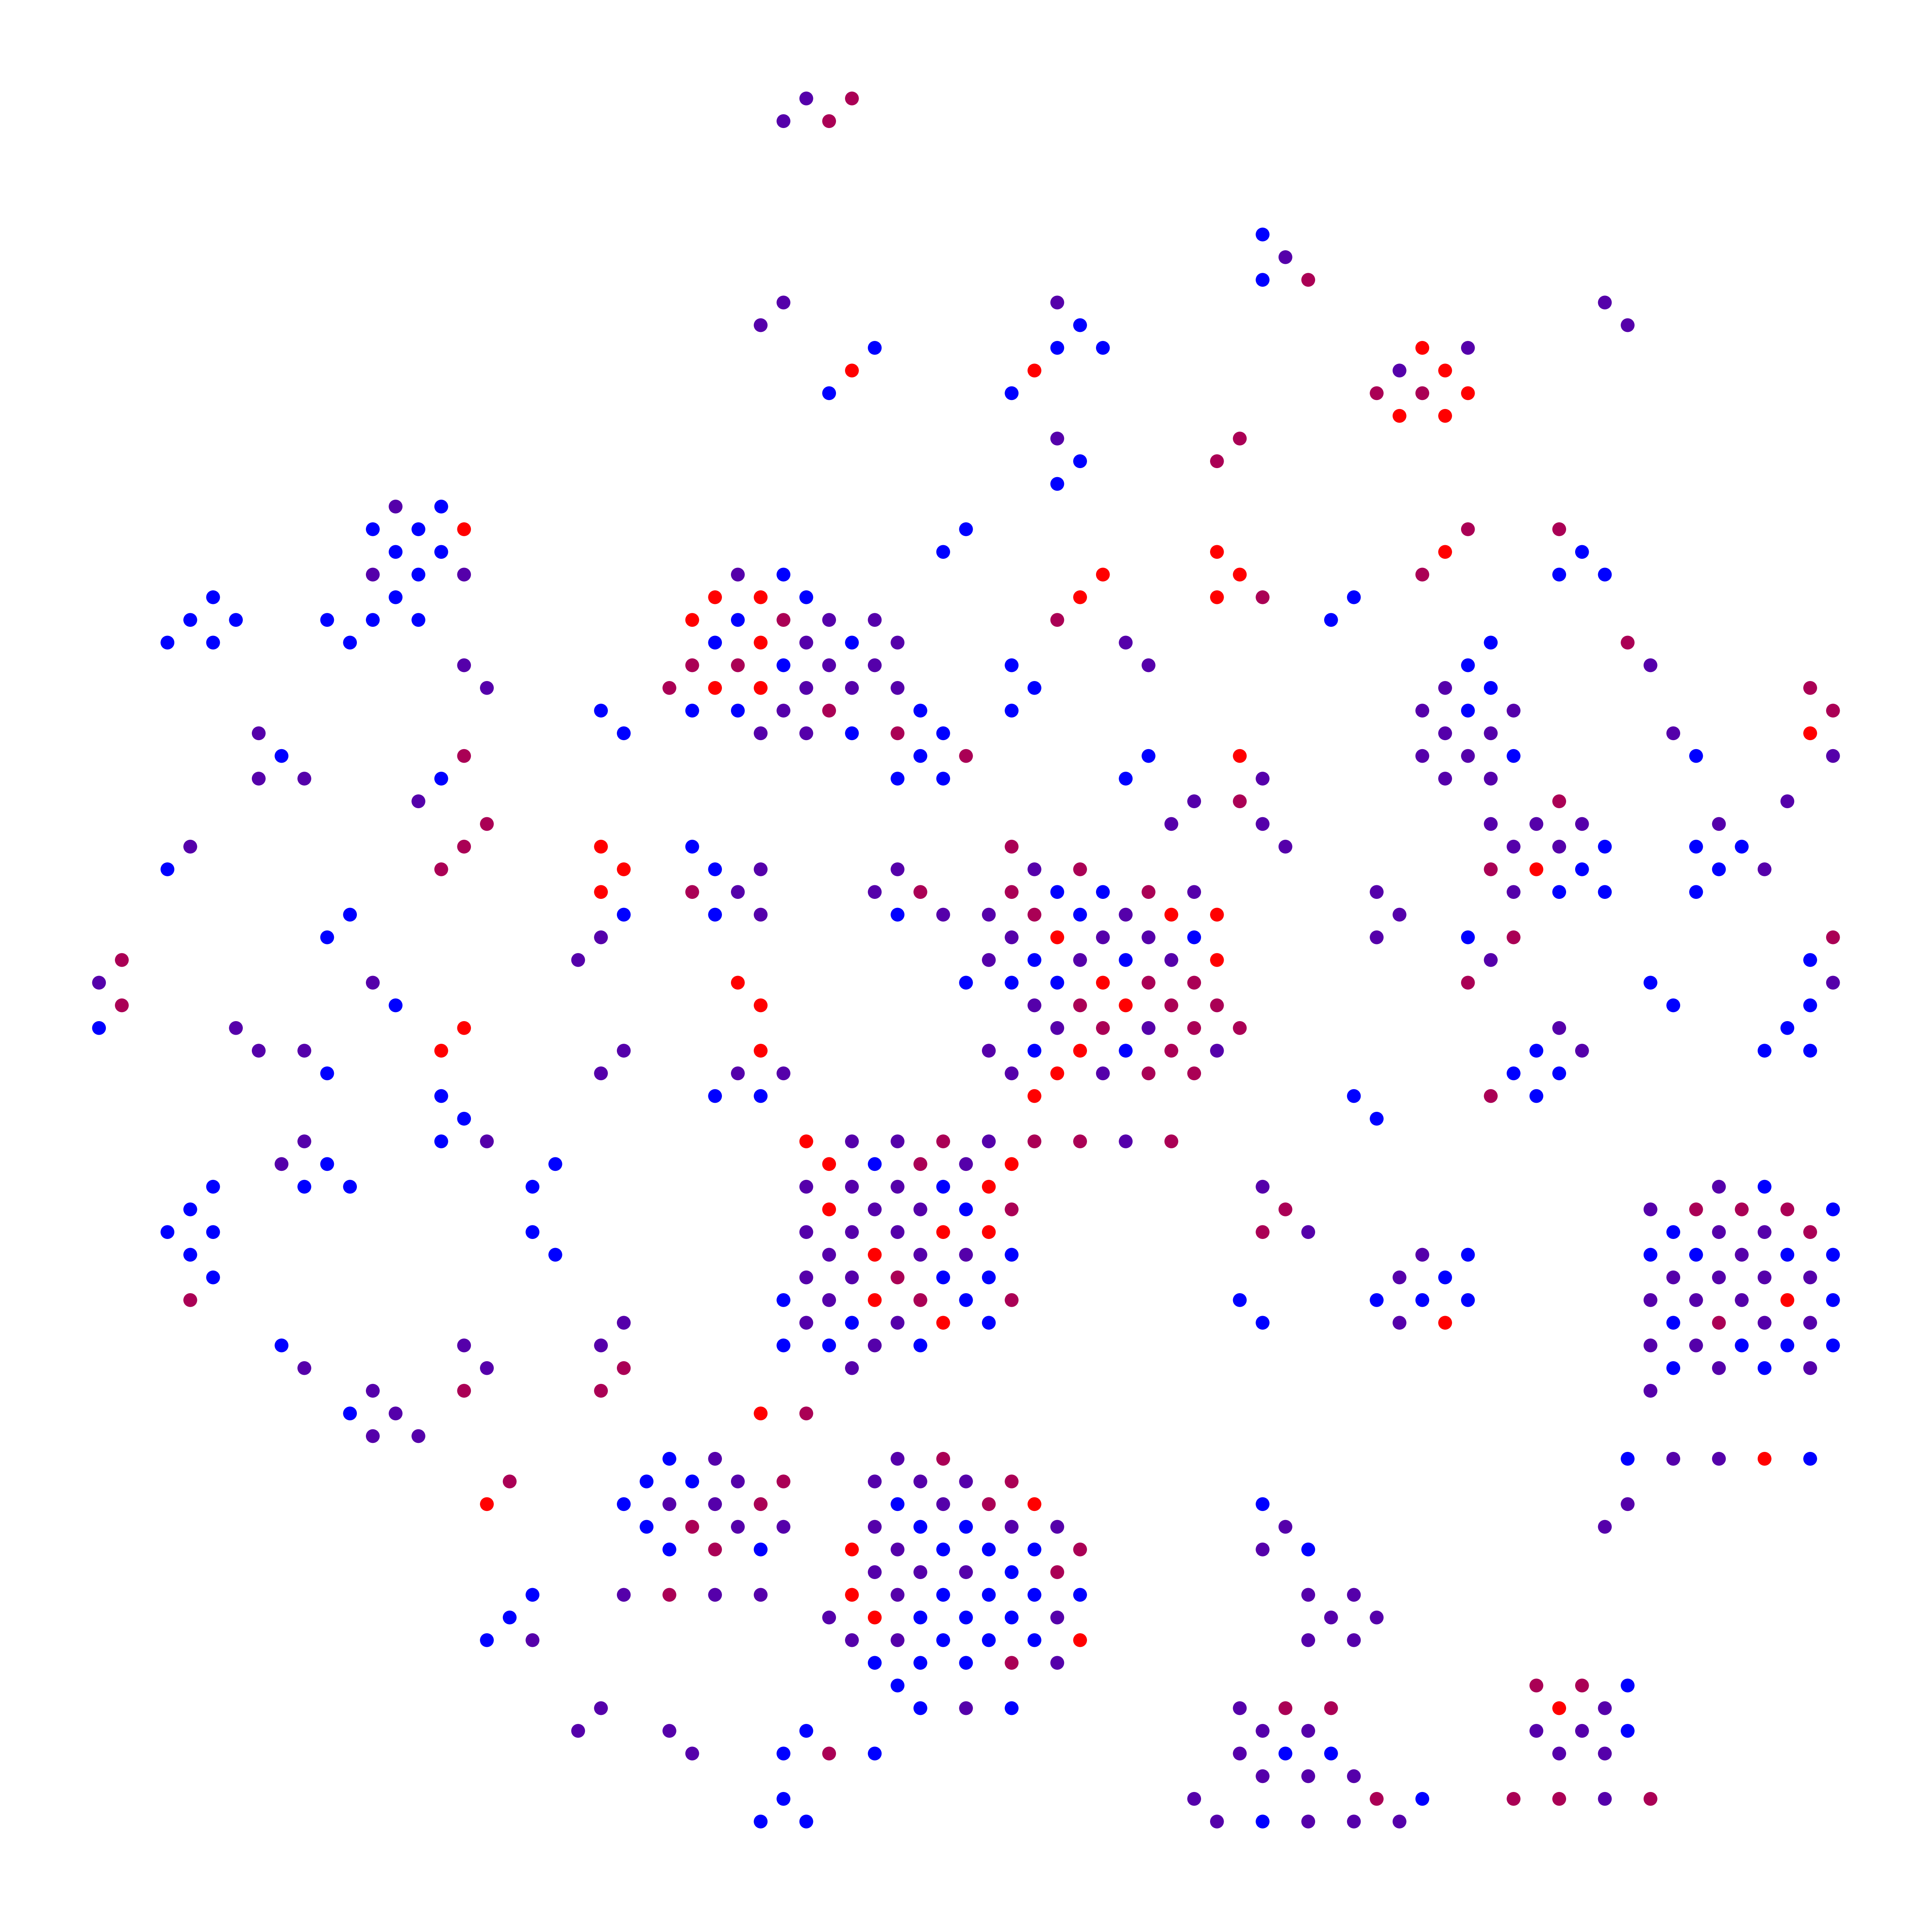

In [26]:
# Fit UMAP reducer without random_state for parallelism
reducer = umap.UMAP(
    random_state=1,
    n_components=2,
    n_neighbors=2,
    min_dist=0.1,
    metric="hellinger"
)

embedding = reducer.fit_transform(train_data) # run UMAP



scaler = MinMaxScaler(feature_range=(100, 900)) # Scale embeddings to a fixed range (100 to 900)
embedding_scaled = scaler.fit_transform(embedding)
embedding_scaled = embedding_scaled.astype(int)

embedding_scaled = align_points_to_grid(embedding_scaled)  # Alignment to a grid

# Assign embeddings (x, y) back to 'entities' DataFrame
index_embedding = 0

for index, row in df.iterrows():
    df.loc[index, "x"] = embedding_scaled[:, 0][index_embedding]
    df.loc[index, "y"] = embedding_scaled[:, 1][index_embedding]
    index_embedding += 1

# Plotting
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot with size based on 'frequency' and color from 'color'
plt.scatter(
    df["x"].to_list(),
    df["y"].to_list(),
    s=50,
    c=df["color"].to_list(),
)

# Labels
# for i, row in df.iterrows():
#     text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
#     text.set_fontsize(3)  # Adjust if too small

# Save the plot
plt.savefig("download.png")


## Clustering

In [27]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=3,
    min_cluster_size=5,
    # cluster_selection_epsilon=50,   # float, optional (default=0.0) A distance threshold. Clusters below this value will be merged.
    # gen_min_span_tree=False,
    # leaf_size=5, # int, optional (default=40) If using a space tree algorithm (kdtree, or balltree) the number of points ina leaf node of the tree. This does not alter the resulting clustering, but may have an effect on the runtime of the algorithm.
)

df["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, df):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            df.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            df.loc[index, "cluster"] = str(clusters[count])
    

cluster_computing(
    df.loc[(df["temperature"] > 0)],
    "p_",
    df,
)
cluster_computing(
    df.loc[(df["temperature"] <= 0)],
    "n_",
    df,
)

df.sample(3)

,title,url,year,entities,temperature,color,x,y,cluster
892,Getty Images promises its new AI contains no c...,https://www.technologyreview.com/2023/09/25/10...,2023,"[the United States, John Grisham, Getty Images...",1,#5500aa,422.077922,349.350649,p_15
283,Digital twins are helping scientists run the w...,https://www.technologyreview.com/2024/06/10/10...,2024,"[NASA, JWST, James Webb Space Telescope, Karen...",2,#0000ff,224.675325,692.207792,p_4
663,Navigating a shifting customer-engagement land...,https://www.technologyreview.com/2023/12/18/10...,2023,"[Akhilesh Ayer, Hurdles, Insights, WNS Triange...",1,#5500aa,224.675325,484.415584,p_7


{'p_14', 'p_4', 'n_7', 'p_6', 'p_17', 'n_1', 'p_7', '-1', 'p_11', 'n_5', 'p_9', 'n_0', 'p_1', 'n_4', 'p_15', 'p_12', 'p_2', 'p_8', 'n_6', 'p_10', 'p_13', 'p_3', 'n_2', 'p_16', 'n_3', 'p_0', 'p_5'}


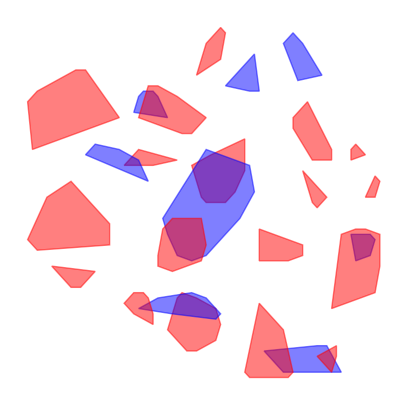

In [28]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(df["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = df.loc[df["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    if len(points) < 3:
        print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#FF0000", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#0000FF", alpha=0.5)  # Plot blue


# Save

In [29]:
export = df.copy()

# export = export.drop(columns="entities")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)


,title,url,year,entities,temperature,color,x,y,cluster
31,AI’s impact on elections is being overblown,https://www.technologyreview.com/2024/09/03/11...,2024,"[the United States, Alan Turing Institute, US,...",2,#0000ff,806.493506,484.415584,-1


In [30]:
# Group by cluster
grouped = df.groupby('cluster')

# Iterate through each cluster and randomly select 10 titles
random_titles_per_cluster = {}

for cluster, group in grouped:
    # Randomly sample 10 titles (or all titles if less than 10)
    sampled_titles = group['title'].sample(n=min(20, len(group)), random_state=1).tolist()
    random_titles_per_cluster[cluster] = sampled_titles

# # Display the result
# for cluster, titles in random_titles_per_cluster.items():
#     print(f"Cluster: {cluster}")
#     for title in titles:
#         print(f"- {title}")

random_titles_per_cluster['p_7']

['Why does AI being good at math matter?',
 'Navigating a shifting customer-engagement landscape with generative AI',
 'MIT Technology Review',
 'How satellite images and AI could help fight spatial apartheid in South Africa',
 'How this Turing Award–winning researcher became a legendary academic advisor',
 'Outperforming competitors as a data-driven organization',
 'Is robotics about to have its own ChatGPT moment?',
 'What are AI agents?',
 'AI can make you more creative—but it has limits',
 'Noise-canceling headphones could let you pick and choose the sounds you want to hear',
 'Noise-canceling headphones use AI to let a single voice through',
 'AI models can outperform humans in tests to identify mental states',
 'Driving companywide efficiencies with AI',
 'A short history of AI, and what it is (and isn’t)',
 'Watch this robot cook shrimp and clean autonomously',
 'AI “godfather” Yoshua Bengio has joined a UK project to prevent AI catastrophes',
 'Why everyone’s excited about hous